In [2]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from model import Encoder, Decoder
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [11]:
# parameters
data_path = './clean.csv'
seed = 123
learning_rate = 0.001
train_batch_size = 128
test_batch_size = 128
num_epochs = 200
device = "cuda" if torch.cuda.is_available() else "cpu"
log_dir = './models/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# set seeds
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(65, 128)
        self.fc2 = nn.Linear(128, 64)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc3 = nn.Linear(64, 1)  

    def forward(self, x):
        x = torch.sigmoid(self.fc3(x))  
        return x

In [5]:
class ClassDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        y = torch.tensor(self.data.iloc[idx, 1], dtype=torch.float32)
        x = torch.tensor(self.data.iloc[idx, 2:].values, dtype=torch.float32)

        if self.transform:
            x = self.transform(x)

        return x, y

In [8]:
def save_checkpoints(encoder, decoder, opt, checkpoint_path):
    save_dict = {}
    save_dict.update({'encoder': encoder.state_dict()})
    save_dict.update({'decoder': decoder.state_dict()})
    save_dict.update({'opt': opt.state_dict()})
    torch.save(save_dict, checkpoint_path)

def load_checkpoints(encoder, decoder, opt, checkpoint_path):
    ckpt = torch.load(checkpoint_path)
    encoder.load_state_dict(ckpt['encoder'])
    decoder.load_state_dict(ckpt['decoder'])
    opt.load_state_dict(ckpt['opt'])

In [9]:
def cal_accuracy(y_pred, y_true):
    y_pred_rounded = torch.round(y_pred)
    correct = (y_pred_rounded == y_true).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

In [10]:
# models
loss_func = torch.nn.MSELoss()

encoder = Encoder().to(device)
decoder = Classifier().to(device)

# optimizer
# opt = optim.Adam(model.parameters(), lr=learning_rate)
opt = optim.SGD(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate,
                    momentum=0.9, weight_decay=5e-4)

# load data
data = pd.read_csv(data_path)

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=seed)

training_data = ClassDataset(train_data)
testing_data = ClassDataset(test_data)

train_loader = DataLoader(training_data, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=test_batch_size, shuffle=False)

In [12]:
training_loss = []
training_acc = []
for epoch in range(1, 1+num_epochs):
    encoder.train()
    decoder.train()
    loss_list = []
    acc_list = []

    for x, y in tqdm(train_loader, desc=f"training epoch #{epoch}"):
        opt.zero_grad()
        embedding = encoder(x.to(device))
        pred = decoder(embedding)
        loss = loss_func(pred.squeeze(), y.to(device))
        acc = cal_accuracy(pred.squeeze(), y.to(device))
        
        loss.backward()
        opt.step()
        loss_list.append(loss.item())
        acc_list.append(acc.item())
    
    epoch_loss = sum(loss_list) / len(loss_list)
    epoch_acc = sum(acc_list) / len(acc_list)
    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc)
    
save_checkpoints(encoder, decoder, opt, os.path.join(log_dir, 'ckpt.pth'))


training epoch #1:   0%|          | 0/229 [00:00<?, ?it/s]

training epoch #200: 100%|██████████| 229/229 [00:01<00:00, 128.34it/s]


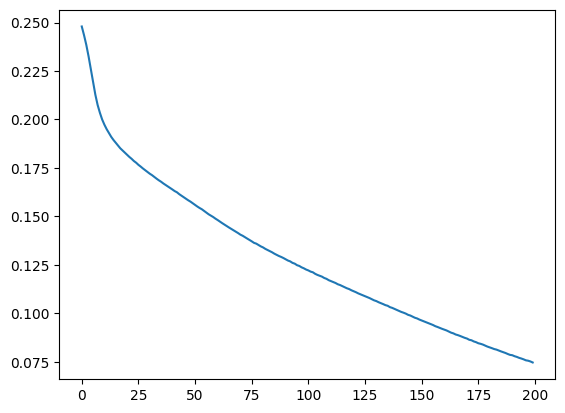

In [13]:
plt.plot(training_loss)

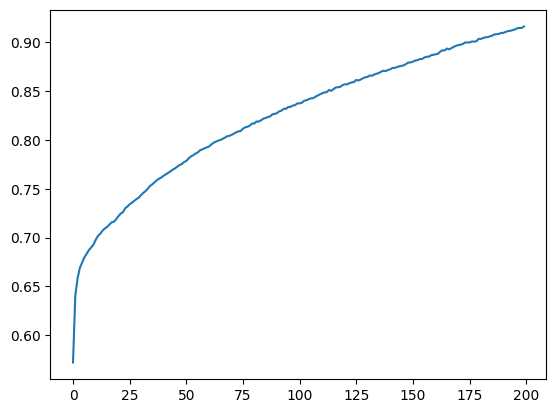

In [14]:
plt.plot(training_acc)

In [21]:
encoder.eval()
decoder.eval()
loss_list = []
acc_list = []

for x, y in tqdm(test_loader, desc="testing"):
    embedding = encoder(x.to(device))
    pred = decoder(embedding)
    loss = loss_func(pred.squeeze(), y.to(device))
    acc = cal_accuracy(pred.squeeze(), y.to(device))
    
    loss_list.append(loss.item())
    acc_list.append(acc.item())

testing_loss = sum(loss_list) / len(loss_list)
testing_acc = sum(acc_list) / len(acc_list)

testing: 100%|██████████| 58/58 [00:00<00:00, 144.19it/s]


In [22]:
print(testing_loss)

0.08890278708061268


In [23]:
print(testing_acc)

0.8886673851259823


In [24]:
# generate embeddings
x = torch.tensor(data.iloc[:, 2:].values, dtype=torch.float32)
embedding = encoder(x.to(device))

In [25]:
embedding.shape

torch.Size([36552, 64])

In [18]:
# save trained embedding
np.save('./embedding.npy', embedding.detach().numpy())